In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cv2;

%matplotlib inline

In [2]:
img = cv2.imread('bathroom_tiles.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

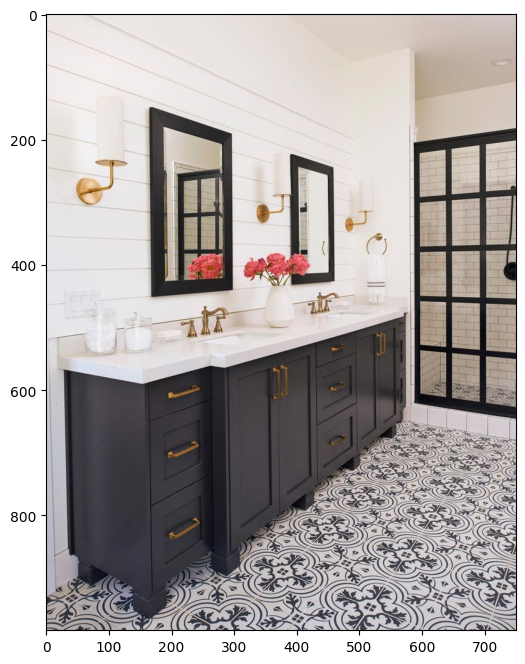

In [3]:
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(img)

In [4]:
X = np.array([[449.0, 822.0],[574.0, 864.0],[517.0, 947.0],[377.0, 891.0]])
Xp = np.array([[200.0, 700.0],[300.0, 700.0],[300.0, 800.0],[200.0, 800.0]])
N = X.shape[0]
X, Xp, N

(array([[449., 822.],
        [574., 864.],
        [517., 947.],
        [377., 891.]]),
 array([[200., 700.],
        [300., 700.],
        [300., 800.],
        [200., 800.]]),
 4)

In [5]:
def make_A_rows(x, xp):
    return np.array([[x[0], x[1], 1.0, 0.0, 0.0, 0.0, -x[0]*xp[0], -x[1]*xp[0], -xp[0]],
                    [0.0, 0.0, 0.0, x[0], x[1], 1.0, -x[0]*xp[1], -x[1]*xp[1], -xp[1]]])

def make_A_matrix(X, Xp):
    N = X.shape[0]
    A = np.empty((2*N, 9), dtype=np.double)
    for i in range(N):
        A[2*i:2*i+2, :] = make_A_rows(X[i, :].flatten(), Xp[i, :].flatten())
    return A

In [6]:
A = make_A_matrix(X, Xp)
A, A.shape

(array([[ 4.490e+02,  8.220e+02,  1.000e+00,  0.000e+00,  0.000e+00,
          0.000e+00, -8.980e+04, -1.644e+05, -2.000e+02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  4.490e+02,  8.220e+02,
          1.000e+00, -3.143e+05, -5.754e+05, -7.000e+02],
        [ 5.740e+02,  8.640e+02,  1.000e+00,  0.000e+00,  0.000e+00,
          0.000e+00, -1.722e+05, -2.592e+05, -3.000e+02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  5.740e+02,  8.640e+02,
          1.000e+00, -4.018e+05, -6.048e+05, -7.000e+02],
        [ 5.170e+02,  9.470e+02,  1.000e+00,  0.000e+00,  0.000e+00,
          0.000e+00, -1.551e+05, -2.841e+05, -3.000e+02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  5.170e+02,  9.470e+02,
          1.000e+00, -4.136e+05, -7.576e+05, -8.000e+02],
        [ 3.770e+02,  8.910e+02,  1.000e+00,  0.000e+00,  0.000e+00,
          0.000e+00, -7.540e+04, -1.782e+05, -2.000e+02],
        [ 0.000e+00,  0.000e+00,  0.000e+00,  3.770e+02,  8.910e+02,
          1.000e+00, -3.016e+05, -7.128e+0

In [7]:
U, S, Vt = np.linalg.svd(A)
np.linalg.norm(U @ np.hstack([np.diag(S), np.zeros((8, 1))]) @ Vt - A)

8.309131719897696e-09

In [8]:
h = Vt[-1, :]
E_alg = np.linalg.norm(A @ h)
h, E_alg

(array([-3.64960121e-04, -6.52804651e-04,  5.83180270e-01,  2.83185639e-04,
        -1.64235256e-03,  8.12340583e-01,  5.41552398e-08, -1.30337367e-06,
         4.60596220e-04]),
 4.239656281634592e-12)

In [9]:
H = h.reshape(3,3)
H / H[2, 2]

array([[-7.92364560e-01, -1.41730353e+00,  1.26614211e+03],
       [ 6.14824061e-01, -3.56571002e+00,  1.76367184e+03],
       [ 1.17576388e-04, -2.82975330e-03,  1.00000000e+00]])

In [10]:
Xpe = H @ (np.hstack([X, np.ones((N, 1))])).T
Xpe /= Xpe[2, :]
E_geom = np.linalg.norm(Xpe[:2, :].T - Xp)
Xpe, E_geom

(array([[200., 300., 300., 200.],
        [700., 700., 800., 800.],
        [  1.,   1.,   1.,   1.]]),
 6.434266690085745e-09)

In [11]:
def getHomography(X, Xp):
    N = X.shape[0]
    assert N >= 4 and N == Xp.shape[0]
    A = make_A_matrix(X, Xp)
    U, S, Vt = np.linalg.svd(A)
    h = Vt[-1, :]
    E_alg = np.linalg.norm(A @ h)
    H = h.reshape(3,3)
    Xpe = H @ (np.hstack([X, np.ones((N, 1))])).T
    Xpe /= Xpe[2, :]
    Xpe = Xpe[:2, :].T
    E_geom = np.linalg.norm(Xpe - Xp)
    return H, Xpe, E_alg, E_geom

In [12]:
H, Xpe, E_alg, E_geom = getHomography(X, Xp)
img_h = cv2.warpPerspective(img, H, img_size, flags=cv2.INTER_CUBIC)
Xpe, E_alg, E_geom

(array([[200., 700.],
        [300., 700.],
        [300., 800.],
        [200., 800.]]),
 4.239656281634592e-12,
 6.434266690085745e-09)

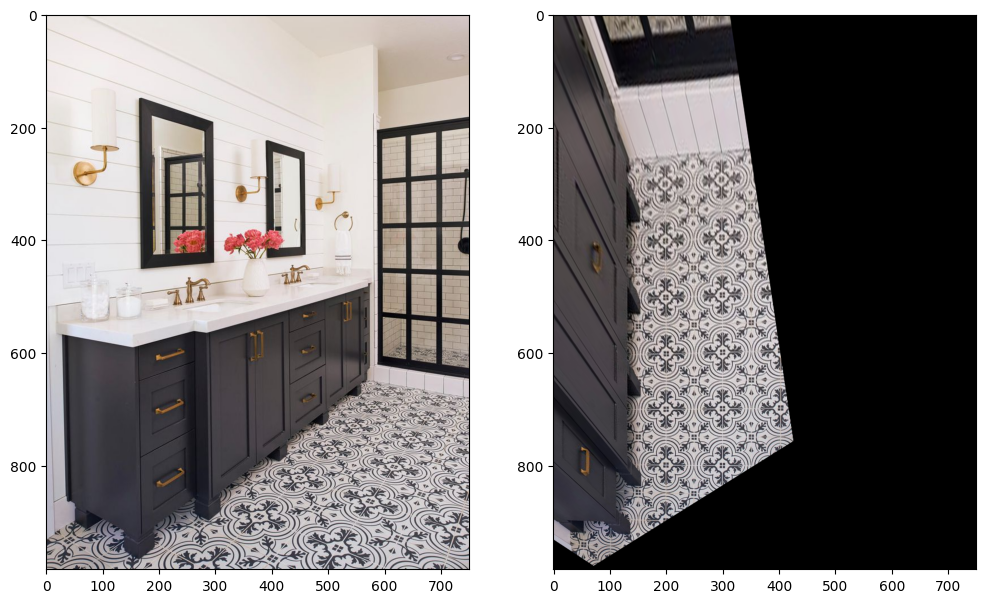

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(img)
axes[1].imshow(img_h)

In [14]:
X8 = np.array([[449.0, 822.0],[574.0, 864.0],[517.0, 947.0],[377.0, 891.0], [507.0, 771.0], [617.0, 802.0], [545.0, 730.0], [649.0, 755.0]])
Xp8 = np.array([[200.0, 700.0],[300.0, 700.0],[300.0, 800.0],[200.0, 800.0], [200.0, 600.0], [300.0, 600.0], [200.0, 500.0], [300.0, 500.0]])

In [15]:
H, Xpe, E_alg, E_geom = getHomography(X8, Xp8)
img_h8 = cv2.warpPerspective(img, H, img_size, flags=cv2.INTER_CUBIC)
Xpe, E_alg, E_geom

(array([[199.36256521, 699.93381075],
        [299.92697578, 700.74230857],
        [300.01440215, 799.65217219],
        [199.86234248, 800.19004098],
        [202.4186593 , 599.37762369],
        [300.12822185, 599.80514889],
        [198.36789778, 500.4017148 ],
        [299.86232299, 499.87500925]]),
 0.0015428477073770198,
 3.208535245985478)

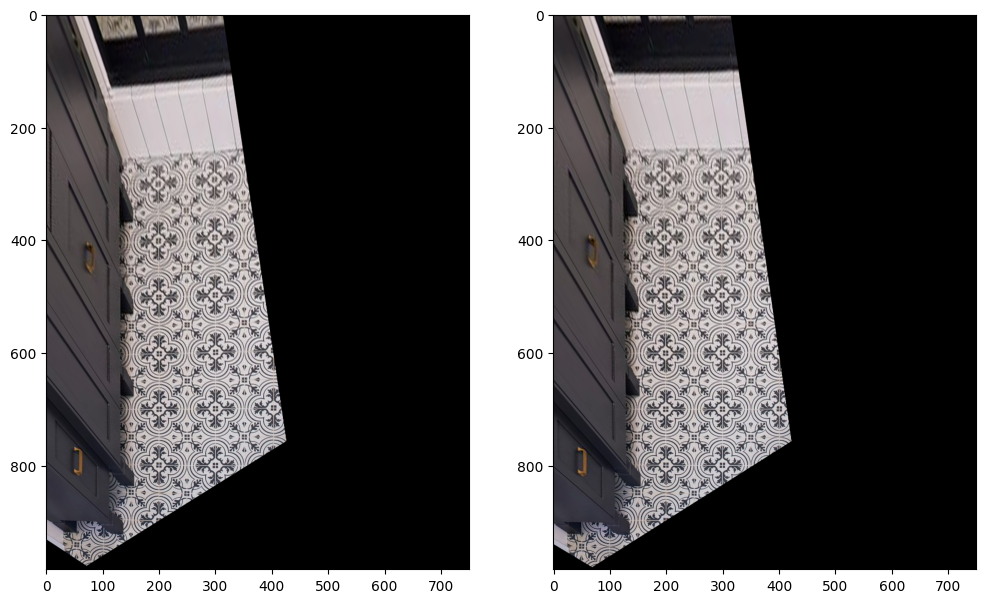

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(img_h)
axes[1].imshow(img_h8)

# Manual Panorama Stitching

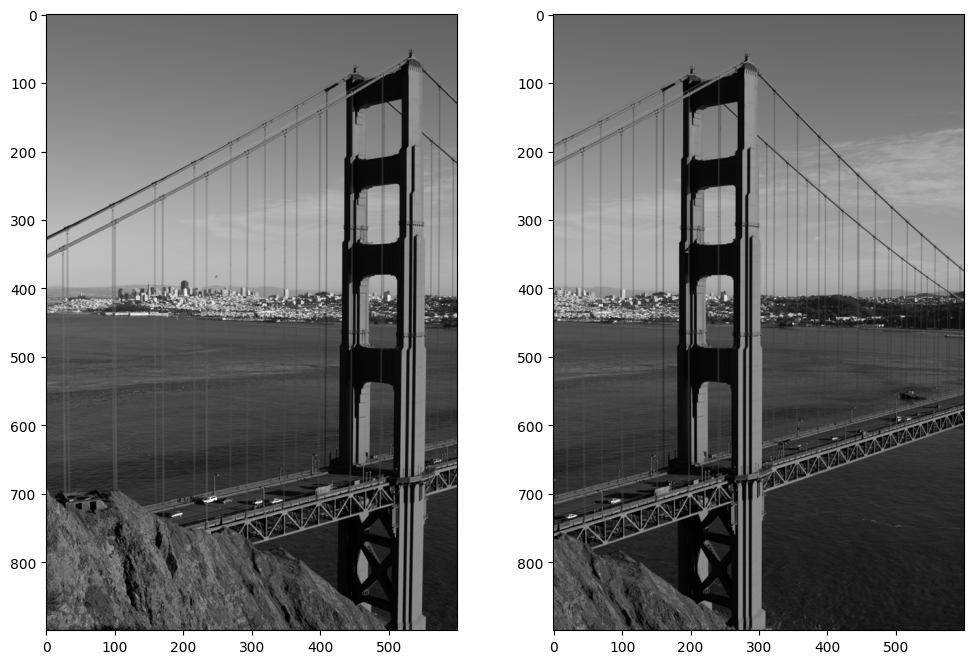

In [17]:
imgL = cv2.imread('goldengate-02.png')
imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
img_size = (imgL.shape[1], imgL.shape[0])
imgR = cv2.imread('goldengate-03.png')
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(imgL)
axes[1].imshow(imgR)

In [18]:
XL = np.array([[354, 401.0], [502, 411.0], [457, 681], [298, 742]])
XR = np.array([[104.0, 402], [253, 411], [212, 680], [52, 748]])

In [19]:
HP, Xpe, E_alg, E_geom = getHomography(XR, XL)
Xpe, E_alg, E_geom

(array([[354., 401.],
        [502., 411.],
        [457., 681.],
        [298., 742.]]),
 2.0922538283041502e-12,
 5.604187418754597e-10)

In [23]:
imgPL = cv2.warpPerspective(imgL, np.eye(3), (img_size[0]*2, img_size[1]))
imgPR = cv2.warpPerspective(imgR, HP, (img_size[0]*2, img_size[1]))

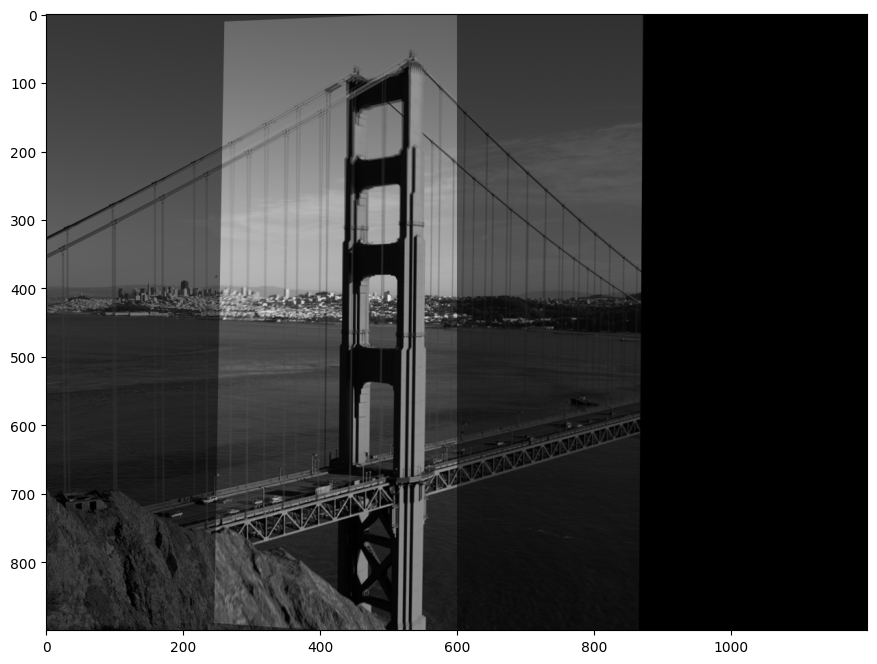

In [26]:
imgAvg = (imgPL / 2.0 + imgPR / 2.0) / 255.0
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(imgAvg)

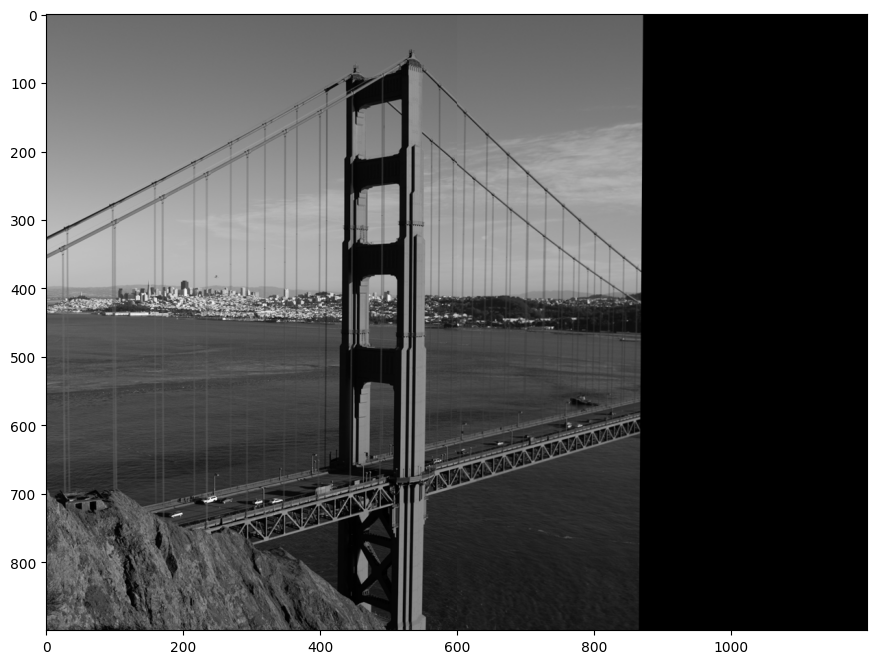

In [21]:
mask = np.zeros(imgPL.shape, dtype = np.uint8)
mask[:img_size[1], :img_size[0]] = 255
imgPL[mask == 0] = imgPR[mask == 0]
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(imgPL)